# Final Project Report

* Class: DS 5100
* Student Name: Javier Alonso
* Student Net ID:fjp8ez
* This URL: a URL to the notebook source of this document

# Instructions

Follow the instructions in the Final Project isntructions notebook and put evidence of your work in this notebook.

Total points for each subsection under **Deliverables** and **Scenarios** are given in parentheses.

Breakdowns of points within subsections are specified within subsection instructions as bulleted lists.

This project is worth **50 points**.

# Deliverables

## The Monte Carlo Module (10)

- URL included, appropriately named (1).
- Includes all three specified classes (3).
- Includes at least all 12 specified methods (6; .5 each).

Put the URL to your GitHub repo here.

Repo URL: https://github.com/notjavo/DS5100-finalproject-fjp8ez

## Monte Carlo Module Code

### Die Class
```python
import numpy as np
import pandas as pd

class Die:
    """
    This class represents a die with N faces and W weights.
    """
    def __init__(self, faces):
        """
        This init function initializes the Die object with corresponding faces and weights.
        """

        if not isinstance(faces, np.ndarray):
            raise TypeError("Faces must be a NumPy array")
        
        #Code below is checking if the elements in faces are unique
        if len(faces) != len(set(faces)):
            raise ValueError("Faces must contain unique values")
        
        #Initialize the faces and weights
        self.faces = faces
        self.weights = np.ones(len(faces))

        #Lastly, the code below is storing the faces and weights in a DataFrame using pandas
        self.die_df = pd.DataFrame({'faces': self.faces, 'weights': self.weights})

    def change_weight(self, face, weight):
        '''
        This method is used to change the wieght of a single face on the die

        Parameters:
        face: The face whos weight needs to be changed
        weight: The new weight of the face (signaled by a Float)
        '''
        #Code below checks to see if the face is valid
        if face not in self.faces:
            raise IndexError("Face is not found on the die")
        #Check if weight is a valid numer (int or float)
        if not isinstance(weight, (int,float)) or weight <= 0:
            raise TypeError("Weight is wrong type or weight must be a positive number")
        self.die_df.loc[self.die_df['faces'] == face, 'weights'] = weight


    def roll(self, num_rolls=1):
        '''
        This method was created to roll the die one or more times

        Parameters:
        num_rolls(int): The number of times to roll the die

        Returns:
        List: A list of outcomes from the rolls '''

        #Code first checks if num_rolls entered is a valid integer 
        if not isinstance(num_rolls,int) or num_rolls <= 0:
            raise TypeError ("Number of rolls given must be an integer and a positive numnber")
        
        # Code below rolls the die using the weights specified 
        outcomes = np.random.choice(self.die_df['faces'], size=num_rolls, p=self.die_df['weights']/self.die_df['weights'].sum())
        return outcomes.tolist()
    

    def show(self):
        '''
        This method shows the current state of the die

        Returns:
        Data Frame: A copy of the private DataFrame with faces and weights '''

        return self.die_df.copy()
```

### Game Class
```python 
class Game:
    ''' This class represents a game consisting of rolling one or more similar dice '''
    def __init__(self,dice):
        '''
        Initializes the Game object with a list of Die objects.

        Parameters:
        dice (list): a list of already instantiated similar Die objects 
        '''
        # Code below checks if the dice list contains only Die objects
        if not all (isinstance(die,Die) for die in dice):
            raise TypeError("All items present in the dice list must be Die objects")
        
        #Code below initializes the list of dice
        self.dice = dice

        #Initialize a DataFrame to store the results of the most recent play
        self._play_df = pd.DataFrame()

    def play(self,num_rolls):
        '''
        Plays the game by rolling all of the dice a given number of time
        Parameters:
        num_rolls (int): The number of times the dice should be rolled
        '''
        #Code below checks to see if number of rolls is an integer, if not, raises a type error
        if not isinstance(num_rolls,int) or num_rolls<=0:
            raise TypeError("Number of rolls should be a positive integer")
        
        #Roll each die and store the outcome
        roll = {f'Die_{i}': die.roll(num_rolls) for i, die in enumerate(self.dice)}

        #Convert results to a DataFrame in wide format
        self._play_df = pd.DataFrame(roll)

    def show(self, form='wide'):
        '''
        Shows the results of the most recent play 
        
        parameters: 
        form (str): The format in which to return the results (input 'wide' or 'narrow')
        ** Form is automatically set to wide but the user can change to narrow if needed**

        Returns:
        DataFrame: The results of the most recent play.

        '''

        #Code below validates the form parameter 
        if form not in ['wide','narrow']:
            raise ValueError("'form must be in either 'wide' or 'narrow' format")
        
        if form == 'wide':
            return self._play_df
        else:
            return self._play_df.stack().reset_index(name='outcome').rename(columns={'level_0': 'roll_number', 'level_1': 'die_number'})
```

### Analyzer Class
```python
class Analyzer:
    """
    A class to analyze the results of a single game and compute various descriptive statistical properties about it.
    """
    
    def __init__(self, game):
        """
        Initializes the Analyzer object with a Game object.
        
        Parameters:
        game (Game): A game object whose results are to be analyzed.
        """
        # Check if the game parameter is an instance of Game
        if not isinstance(game, Game):
            raise ValueError("The input parameter must be a Game object")
        
        # Initialize the game object
        self.game = game
    
    def jackpot(self):
        """
        Computes how many times the game resulted in a jackpot.
        
        A jackpot is a result in which all faces are the same.
        
        Returns:
        int: The number of jackpots.
        """
        # Check if the game has been played
        if self.game._play_df.empty:
            return 0
        
        # Compute the number of jackpots
        jackpots = (self.game._play_df.nunique(axis=1) == 1).sum()
        return jackpots
    
    def face_counts(self):
        """
        Computes how many times a given face is rolled in each event.
        
        Returns:
        DataFrame: A DataFrame with the roll number as index, face values as columns, and count values in the cells.
        """
        # Check if the game has been played
        if self.game._play_df.empty:
            return pd.DataFrame()
        
        # Compute the face counts per roll
        face_counts = self.game._play_df.apply(pd.Series.value_counts, axis=1).fillna(0).astype(int)
        face_counts.index.name = 'roll_number'
        return face_counts
    
    def combo_counts(self):
        """
        Computes the distinct combinations of faces rolled, along with their counts.
        
        Combinations are order-independent and may contain repetitions.
        
        Returns:
        DataFrame: A DataFrame with a MultiIndex of distinct combinations and a column for the associated counts.
        """
        # Check if the game has been played
        if self.game._play_df.empty:
            return pd.DataFrame()
        
        # Compute the combinations and their counts
        combos = self.game._play_df.apply(lambda x: tuple(sorted(x)), axis=1).value_counts().reset_index()
        combos.columns = ['combo', 'count']
        combos.set_index('combo', inplace=True)
        return combos
    
    def permutation_counts(self):
        """
        Computes the distinct permutations of faces rolled, along with their counts.
        
        Permutations are order-dependent and may contain repetitions.
        
        Returns:
        DataFrame: A DataFrame with a MultiIndex of distinct permutations and a column for the associated counts.
        """
        # Check if the game has been played
        if self.game._play_df.empty:
            return pd.DataFrame()
        
        # Compute the permutations and their counts
        perms = self.game._play_df.apply(tuple, axis=1).value_counts().reset_index()
        perms.columns = ['permutation', 'count']
        perms.set_index('permutation', inplace=True)
        return perms
```

## Unitest Module (2)

Paste a copy of your test module below.

NOTE: Paste as text, not as code. Use triple backticks to wrap your code blocks.

- All methods have at least one test method (1).
- Each method employs one of Unittest's Assert methods (1).

#### Unit Test Code Die Class
```python 
import unittest
import numpy as np
import pandas as pd
from montecarlo import Die, Game, Analyzer

class TestDie(unittest.TestCase):
    def setUp(self):
        self.faces = np.array([1, 2, 3, 4, 5, 6])
        self.die = Die(self.faces)

    def test_initialization(self):
        self.assertTrue(isinstance(self.die.faces, np.ndarray))
        self.assertEqual(len(self.die.faces), len(self.faces))
        self.assertEqual(len(self.die.weights), len(self.faces))
        self.assertTrue((self.die.weights == 1).all())

    def test_change_weight(self):
        self.die.change_weight(1, 5)
        self.assertEqual(self.die.die_df.loc[self.die.die_df['faces'] == 1, 'weights'].values[0], 5)

    def test_roll(self):
        rolls = self.die.roll(10)
        self.assertEqual(len(rolls), 10)

#### Unit Test Code for Game Class
```python
class TestGame(unittest.TestCase):
    def setUp(self):
        self.faces = np.array([1, 2, 3, 4, 5, 6])
        self.dice = [Die(self.faces) for _ in range(5)]
        self.game = Game(self.dice)

    def test_initialization(self):
        self.assertTrue(all(isinstance(die, Die) for die in self.game.dice))

    def test_play(self):
        self.game.play(10)
        self.assertEqual(len(self.game._play_df), 10)

    def test_show(self):
        self.game.play(10)
        df = self.game.show()
        self.assertEqual(df.shape, (10, 5))
```

#### Unit Test Code for Analyzer Class
```python 
class TestAnalyzer(unittest.TestCase):
    def setUp(self):
        self.faces = np.array([1, 2, 3, 4, 5, 6])
        self.dice = [Die(self.faces) for _ in range(5)]
        self.game = Game(self.dice)
        self.game.play(10)
        self.analyzer = Analyzer(self.game)

    def test_init(self):
        with self.assertRaises(ValueError):
            Analyzer("not_a_game_object")

    def test_jackpot(self):
        self.game._play_df.iloc[0] = [1, 1, 1, 1, 1]
        self.assertEqual(self.analyzer.jackpot(), 1)

    def test_face_counts(self):
        face_counts = self.analyzer.face_counts()
        self.assertIsInstance(face_counts, pd.DataFrame)
        self.assertEqual(face_counts.shape[0], 10)  # 10 rolls
        self.assertEqual(face_counts.shape[1], len(self.faces))  
        self.assertTrue((face_counts.sum(axis=1) == len(self.dice)).all())

    def test_combo_counts(self):
        combo_counts = self.analyzer.combo_counts()
        self.assertGreater(len(combo_counts), 0)

    def test_permutation_counts(self):
        permutation_counts = self.analyzer.permutation_counts()
        self.assertGreater(len(permutation_counts), 0)

if __name__ == '__main__':
    unittest.main()
```

## Unittest Results (3)

Put a copy of the results of running your tests from the command line here.

Again, paste as text using triple backticks.

- All 12 specified methods return OK (3; .25 each).

#Successful Unit Testing
```bash
python montecarlo_test.py
You have officially installed the Monte Carlo package!
you have offically installed the montecarlo package!
............
----------------------------------------------------------------------
Ran 12 tests in 0.016s

OK
```


## Import (1)

Import your module here. This import should refer to the code in your package directory.

- Module successuflly imported (1).

In [1661]:
# e.g. import montecarlo.montecarlo 
import montecarlo.montecarlo
from montecarlo import Die, Game, Analyzer

## Help Docs (4)

Show your docstring documentation by applying `help()` to your imported module.

- All methods have a docstring (3; .25 each).
- All classes have a docstring (1; .33 each).

In [1662]:
help(montecarlo)

Help on package montecarlo:

NAME
    montecarlo - Monte Carlo Simulation Package

DESCRIPTION
    This package includes the following modules:
    - Die: A class to represent a die with faces and weights.
    - Game: A class to handle multiple dice and play a game with them.
    - Analyzer: A class to analyze the results of the game.

    Example usage:
        from montecarlo import Die, Game, Analyzer

        # Create a die
        die = Die(faces=np.array([1, 2, 3, 4, 5, 6]))

        # Create a game with two dice
        game = Game(dice=[die, die])

        # Play the game
        game.play(num_rolls=1000)

        # Analyze the results
        analyzer = Analyzer(game=game)
        print(analyzer.face_counts())

PACKAGE CONTENTS
    montecarlo

FILE
    /Users/notjavo/miniconda3/lib/python3.12/site-packages/montecarlo/__init__.py




In [1663]:
help(Die)

Help on class Die in module montecarlo.montecarlo:

class Die(builtins.object)
 |  Die(faces)
 |
 |  This class represents a die with N faces and W weights.
 |
 |  Methods defined here:
 |
 |  __init__(self, faces)
 |      This init function initializes the Die object with corresponding faces and weights.
 |
 |  change_weight(self, face, weight)
 |      This method is used to change the wieght of a single face on the die
 |
 |      Parameters:
 |      face: The face whos weight needs to be changed
 |      weight: The new weight of the face (signaled by a Float)
 |
 |  roll(self, num_rolls=1)
 |      This method was created to roll the die one or more times
 |
 |      Parameters:
 |      num_rolls(int): The number of times to roll the die
 |
 |      Returns:
 |      List: A list of outcomes from the rolls
 |
 |  show(self)
 |      This method shows the current state of the die
 |
 |      Returns:
 |      Data Frame: A copy of the private DataFrame with faces and weights
 |
 |  ---------

In [1664]:
help(Game)


Help on class Game in module montecarlo.montecarlo:

class Game(builtins.object)
 |  Game(dice)
 |
 |  This class represents a game consisting of rolling one or more similar dice
 |
 |  Methods defined here:
 |
 |  __init__(self, dice)
 |      Initializes the Game object with a list of Die objects.
 |
 |      Parameters:
 |      dice (list): a list of already instantiated similar Die objects
 |
 |  play(self, num_rolls)
 |      Plays the game by rolling all of the dice a given number of time
 |      Parameters:
 |      num_rolls (int): The number of times the dice should be rolled
 |
 |  show(self, form='wide')
 |      Shows the results of the most recent play
 |
 |      parameters:
 |      form (str): The format in which to return the results (input 'wide' or 'narrow')
 |      ** Form is automatically set to wide but the user can change to narrow if needed**
 |
 |      Returns:
 |      DataFrame: The results of the most recent play.
 |
 |  ---------------------------------------------

In [1665]:
help(Analyzer)

Help on class Analyzer in module montecarlo.montecarlo:

class Analyzer(builtins.object)
 |  Analyzer(game)
 |
 |  A class to analyze the results of a single game and compute various descriptive statistical properties about it.
 |
 |  Methods defined here:
 |
 |  __init__(self, game)
 |      Initializes the Analyzer object with a Game object.
 |
 |      Parameters:
 |      game (Game): A game object whose results are to be analyzed.
 |
 |  combo_counts(self)
 |      Computes the distinct combinations of faces rolled, along with their counts.
 |
 |      Combinations are order-independent and may contain repetitions.
 |
 |      Returns:
 |      DataFrame: A DataFrame with a MultiIndex of distinct combinations and a column for the associated counts.
 |
 |  face_counts(self)
 |      Computes how many times a given face is rolled in each event.
 |
 |      Returns:
 |      DataFrame: A DataFrame with the roll number as index, face values as columns, and count values in the cells.
 |
 |  jack

## `README.md` File (3)

Provide link to the README.md file of your project's repo.

- Metadata section or info present (1).
- Synopsis section showing how each class is called (1). (All must be included.)
- API section listing all classes and methods (1). (All must be included.)

URL: https://github.com/notjavo/DS5100-finalproject-fjp8ez/blob/main/README.md

## Successful installation (2)

Put a screenshot or paste a copy of a terminal session where you successfully install your module with pip.

If pasting text, use a preformatted text block to show the results.

- Installed with `pip` (1).
- Successfully installed message appears (1).

# Instalation Code
```bash
pip install .
Processing /Users/notjavo/Documents/MSDS/DS5100/DS5100-finalproject-fjp8ez
  Preparing metadata (setup.py) ... done
Building wheels for collected packages: Montecarlo
  Building wheel for Montecarlo (setup.py) ... done
  Created wheel for Montecarlo: filename=Montecarlo-1.0.0-py3-none-any.whl size=4973 sha256=b92d4c88b952ac71aec4641063f6a8e82f0fd7dec822e534160d5028900a843c
  Stored in directory: /Users/notjavo/Library/Caches/pip/wheels/0c/3d/19/a59e26e916ab81e2118cce77a4858ddb083a33f4f994740506
Successfully built Montecarlo
Installing collected packages: Montecarlo
Successfully installed Montecarlo-1.0.0
```

# Scenarios

Use code blocks to perform the tasks for each scenario.

Be sure the outputs are visible before submitting.

## Scenario 1: A 2-headed Coin (9)

Task 1. Create a fair coin (with faces $H$ and $T$) and one unfair coin in which one of the faces has a weight of $5$ and the others $1$.

- Fair coin created (1).
- Unfair coin created with weight as specified (1).

In [1666]:
import numpy as np
import pandas as pd

In [1667]:
#Creating Fair Coin
fair_coin_faces = np.array(['H','T'])
fair_coin = Die(faces=fair_coin_faces)

#Creating Unfair Coin
unfair_coin_faces = np.array(['H','T'])
unfair_coin = Die(faces=unfair_coin_faces)
unfair_coin.change_weight(face='H', weight=5)

In [1668]:
print(fair_coin.die_df)

  faces  weights
0     H      1.0
1     T      1.0


In [1669]:
print(unfair_coin.die_df)

  faces  weights
0     H      5.0
1     T      1.0


Task 2. Play a game of $1000$ flips with two fair dice.

- Play method called correclty and without error (1).

In [1670]:
fair_game = Game(dice=[fair_coin, fair_coin])
fair_game.play(num_rolls=1000)
#Display results of game with analyzer
fair_game_results = Analyzer(fair_game)
print(fair_game_results.face_counts())

             H  T
roll_number      
0            1  1
1            2  0
2            1  1
3            1  1
4            0  2
...         .. ..
995          0  2
996          2  0
997          1  1
998          1  1
999          0  2

[1000 rows x 2 columns]


Task 3. Play another game (using a new Game object) of $1000$ flips, this time using two unfair dice and one fair die. For the second unfair die, you can use the same die object twice in the list of dice you pass to the Game object.

- New game object created (1).
- Play method called correclty and without error (1).

In [1671]:
unfair_game = Game(dice=[unfair_coin,unfair_coin])
unfair_game.play(num_rolls=1000)
#Next block displays the results
unfair_game_results = Analyzer(unfair_game)
print(unfair_game_results.face_counts())

             H  T
roll_number      
0            2  0
1            2  0
2            2  0
3            2  0
4            1  1
...         .. ..
995          2  0
996          2  0
997          2  0
998          2  0
999          2  0

[1000 rows x 2 columns]


Task 4. For each game, use an Analyzer object to determine the raw frequency of jackpots — i.e. getting either all $H$s or all $T$s.

- Analyzer objecs instantiated for both games (1).
- Raw frequencies reported for both (1).

In [1672]:
fair_jackpots = fair_game_results.jackpot()
print(fair_jackpots)



484


In [1673]:
unfair_jackpots = unfair_game_results.jackpot()
print(unfair_jackpots)

749


Task 5. For each analyzer, compute relative frequency as the number of jackpots over the total number of rolls.

- Both relative frequencies computed (1).

In [1674]:
total_rolls = 1000
fair_freq = fair_jackpots / total_rolls
unfair_freq = unfair_jackpots / total_rolls

In [1675]:
print(fair_freq)

0.484


In [1676]:
print(unfair_freq)

0.749


Task 6. Show your results, comparing the two relative frequencies, in a simple bar chart.

- Bar chart plotted and correct (1).

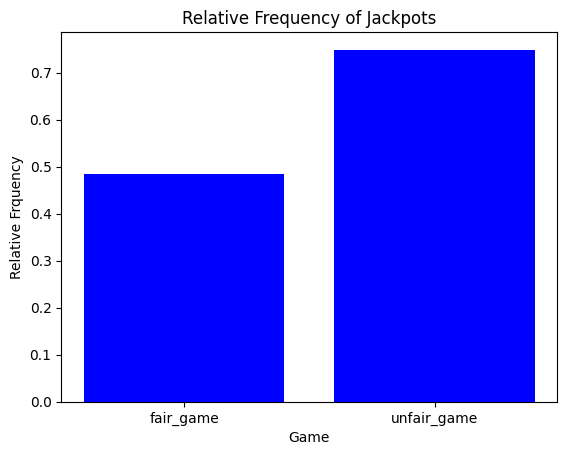

In [1677]:
import matplotlib.pyplot as plt

games = ['fair_game', 'unfair_game']
frequencies = [fair_freq,unfair_freq]

#bar chart code
plt.bar(games,frequencies,color='blue')
plt.title('Relative Frequency of Jackpots')
plt.xlabel('Game')
plt.ylabel('Relative Frquency')
plt.show()

## Scenario 2: A 6-sided Die (9)

Task 1. Create three dice, each with six sides having the faces 1 through 6.

- Three die objects created (1).

In [1678]:
faces = np.array([1,2,3,4,5,6])
die1 = Die(faces=faces)
die2 = Die(faces=faces)
die3 = Die(faces=faces)
#print(die1.show())

Task 2. Convert one of the dice to an unfair one by weighting the face $6$ five times more than the other weights (i.e. it has weight of 5 and the others a weight of 1 each).

- Unfair die created with proper call to weight change method (1).

In [1679]:
die2.change_weight(6,5)
print(die2.show())

   faces  weights
0      1      1.0
1      2      1.0
2      3      1.0
3      4      1.0
4      5      1.0
5      6      5.0


Task 3. Convert another of the dice to be unfair by weighting the face $1$ five times more than the others.

- Unfair die created with proper call to weight change method (1).

In [1680]:
die3.change_weight(1,5)
print(die3.show())

   faces  weights
0      1      5.0
1      2      1.0
2      3      1.0
3      4      1.0
4      5      1.0
5      6      1.0


Task 4. Play a game of $10000$ rolls with $5$ fair dice.

- Game class properly instantiated (1). 
- Play method called properly (1).

In [1681]:
die11=Die(faces=faces)
die12=Die(faces=faces)
die13=Die(faces=faces)
die14=Die(faces=faces)
die15=Die(faces=faces)

new_game = Game(dice=[die11,die12,die13,die14,die15])

new_game.play(num_rolls=10000)
new_game_results = new_game.show('wide')
print(new_game_results)

      Die_0  Die_1  Die_2  Die_3  Die_4
0         2      3      1      3      2
1         4      3      4      5      4
2         3      3      4      3      6
3         2      5      6      4      4
4         4      3      4      4      1
...     ...    ...    ...    ...    ...
9995      2      1      1      6      3
9996      3      5      5      3      1
9997      6      5      4      1      1
9998      2      4      5      1      6
9999      1      1      6      3      6

[10000 rows x 5 columns]


Task 5. Play another game of $10000$ rolls, this time with $2$ unfair dice, one as defined in steps #2 and #3 respectively, and $3$ fair dice.

- Game class properly instantiated (1). 
- Play method called properly (1).

In [1682]:
newest_game = Game(dice=[die11,die12,die13,die2,die3])
newest_game.play(num_rolls=10000)

newest_game_results = newest_game.show('wide')
print(newest_game_results)

      Die_0  Die_1  Die_2  Die_3  Die_4
0         1      2      1      6      6
1         4      5      6      3      2
2         2      6      1      2      1
3         6      5      5      1      1
4         6      1      3      6      6
...     ...    ...    ...    ...    ...
9995      1      1      4      1      4
9996      6      5      1      2      1
9997      3      6      3      2      3
9998      2      1      5      6      2
9999      4      6      4      6      1

[10000 rows x 5 columns]


Task 6. For each game, use an Analyzer object to determine the relative frequency of jackpots and show your results, comparing the two relative frequencies, in a simple bar chart.

- Jackpot methods called (1).
- Graph produced (1).

In [1683]:
# Calculating jackpot for all fair game
new_game_analyzer = Analyzer(new_game)
new_game_jackpots = new_game_analyzer.jackpot()
total_rolls_new_game = 10000
relative_freq_new_game = new_game_jackpots / total_rolls
print(relative_freq_new_game)

0.005


In [1684]:
#Calculating jackpots for unfair dice rolls
newest_game_analyzer = Analyzer(newest_game)
newest_game_jackpots = newest_game_analyzer.jackpot()
total_rolls_newest_game = 10000
relative_freq_newest_game = new_game_jackpots / total_rolls_newest_game
print(relative_freq_newest_game)

0.0005


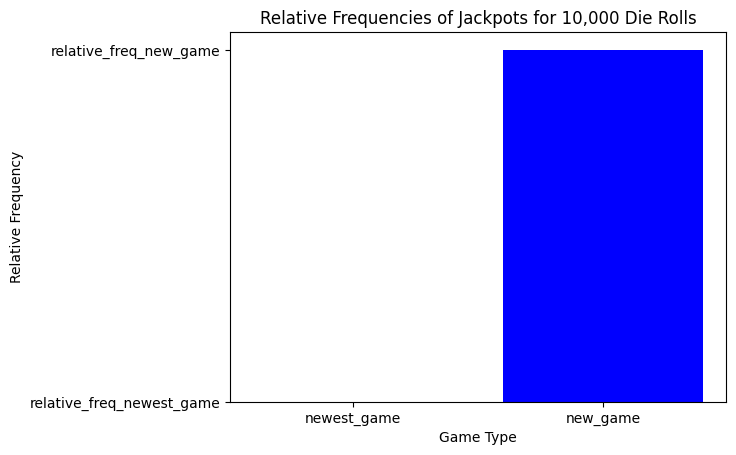

In [1685]:
games_df = ['newest_game', 'new_game']
frequencies_df = ['relative_freq_newest_game','relative_freq_new_game']

plt.bar(games_df, frequencies_df, color='blue')
plt.title('Relative Frequencies of Jackpots for 10,000 Die Rolls')
plt.xlabel('Game Type')
plt.ylabel('Relative Frequency')
plt.show()

## Scenario 3: Letters of the Alphabet (7)

Task 1. Create a "die" of letters from $A$ to $Z$ with weights based on their frequency of usage as found in the data file `english_letters.txt`. Use the frequencies (i.e. raw counts) as weights.

- Die correctly instantiated with source file data (1).
- Weights properly applied using weight setting method (1).

In [1686]:
letters_df = pd.read_csv("english_letters.txt",sep=" ", header=None, names=['Letter','Frequency'])
letters_df

,Letter,Frequency
0,E,529117365
1,T,390965105
2,A,374061888
3,O,326627740
4,I,320410057
5,N,313720540
6,S,294300210
7,R,277000841
8,H,216768975
9,L,183996130


In [1687]:
letters = letters_df["Letter"].values
frequency = letters_df["Frequency"].values.astype(int)


In [1688]:
letter_die = Die(faces=letters)

In [1689]:
#letter_die.die_df['weights'] = frequencies
letter_die.die_df['weights'] = frequency
letter_die.show()



,faces,weights
0,E,529117365
1,T,390965105
2,A,374061888
3,O,326627740
4,I,320410057
5,N,313720540
6,S,294300210
7,R,277000841
8,H,216768975
9,L,183996130


Task 2. Play a game involving $4$ of these dice with $1000$ rolls.

- Game play method properly called (1).

In [1690]:
letters_game = Game(dice=[letter_die,letter_die,letter_die,letter_die])
letters_game.play(num_rolls=1000)
letters_game.show()

,Die_0,Die_1,Die_2,Die_3
0,A,L,S,H
1,A,T,W,E
2,Y,W,O,I
3,B,D,L,T
4,U,S,I,N
...,...,...,...,...
995,L,I,I,L
996,G,S,E,W
997,C,H,N,A
998,T,F,C,E


Task 3. Determine how many permutations in your results are actual English words, based on the vocabulary found in `scrabble_words.txt`.

- Use permutation method (1).
- Get count as difference between permutations and vocabulary (1).

In [1705]:
#First load in the scrabble words text file
scrabble_words = pd.read_csv('scrabble_words.txt', header=None, names=['Words'])
scrabble_words_df = set(scrabble_words["Words"].str.strip())

In [1692]:
letter_game_analyzer = Analyzer(letters_game)

In [1693]:
letter_game_perms = letter_game_analyzer.permutation_counts()

In [1694]:
#use the loop to see if perms are actual english words
actual_words_count = 0
total_permutations = letter_game_perms.shape[0]

for permutation in letter_game_perms.index:
    perm_str = ''.join(permutation)
    if permutation in scrabble_words_df:
        actual_words_count += letter_game_perms[permutation]


In [1695]:
#Calculate Dif 
invalid_words_count = total_permutations - actual_words_count

In [1696]:
total_rolls=1000
valid_permutations= total_rolls-invalid_words_count

In [1697]:
print(f"Invalid permutations count: {invalid_words_count}")
print(f"Permutations that are apart of English Language: {valid_permutations}")

Invalid permutations count: 989
Permutations that are apart of English Language: 11


Task 4. Repeat steps #2 and #3, this time with $5$ dice. How many actual words does this produce? Which produces more?

- Successfully repreats steps (1).
- Identifies parameter with most found words (1).

In [1698]:
new_letter_game = Game(dice=[letter_die,letter_die,letter_die,letter_die,letter_die])
new_letter_game.play(num_rolls=1000)


In [1699]:
new_letter_game_analyzer = Analyzer(new_letter_game)

In [1700]:
new_letter_game_perms = new_letter_game_analyzer.permutation_counts()

In [1701]:
new_actual_words_count = 0
new_total_permutations = new_letter_game_perms.shape[0]

for permutation in new_letter_game_perms.index:
    perm_str = ''.join(permutation)
    if permutation in scrabble_words_df:
        new_actual_words_count += new_letter_game_perms[permutation]





In [1702]:
new_invalid_words_count = new_total_permutations - new_actual_words_count

In [1703]:
total_rolls=1000
new_valid_permutations= total_rolls-new_invalid_words_count

In [1704]:
print(f"Invalid permutations count: {new_invalid_words_count}")
print(f"Permutations that are apart of English Language: {new_valid_permutations}")

Invalid permutations count: 999
Permutations that are apart of English Language: 1
